## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**MiCASA Land Carbon Flux**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/micasa-carbonflux-daygrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 0.1° x 0.1°
- **Temporal extent**: January 1, 2001 - December 31, 2023
- **Temporal resolution**: Daily and Monthly Averages
- **Unit**: Grams of Carbon per square meter per day
- **Utility**: Climate Research

For more, visit the [MiCASA Land Carbon Flux](https://earth.gov/ghgcenter/data-catalog/micasa-carbonflux-grid-v1) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for a given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmosphere Carbon Flux data product
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison
4. After the visualization, perform zonal statistics for a given polygon

## About the Data

This dataset presents a variety of carbon flux parameters derived from the Más Informada Carnegie-Ames-Stanford-Approach (MiCASA) model. The model’s input data includes air temperature, precipitation, incident solar radiation, a soil classification map, and several satellite derived products. All model calculations are driven by analyzed meteorological data from NASA’s Modern-Era Retrospective analysis for Research and Application, Version 2 (MERRA-2). The resulting product provides global, daily data at 0.1 degree resolution from January 2001 through December 2023. It includes carbon flux variables expressed in units of kilograms of carbon per square meter per day (kg Carbon/m²/day) from net primary production (NPP), heterotrophic respiration (Rh), wildfire emissions (FIRE), fuel wood burning emissions (FUEL), net ecosystem exchange (NEE), and net biosphere exchange (NBE). The latter two are derived from the first four (see Scientific Details below). MiCASA is an extensive revision of the CASA – Global Fire Emissions Database, version 3 (CASA-GFED3) product. CASA-GFED3 and earlier versions of MERRA-driven CASA-GFED carbon fluxes have been used in several atmospheric carbon dioxide (CO₂) transport studies, serve as a community standard for priors of flux inversion systems, and through the support of NASA’s Carbon Monitoring System (CMS), help characterize, quantify, understand and predict the evolution of global carbon sources and sinks.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt
from stats_module import generate_stats, clean_stats, display_stats

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for MiCASA Land Carbon Flux

#collection_name = "micasa-carbonflux-daygrid-v1" for daily data
collection_name = "micasa-carbonflux-monthgrid-v1"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the MiCASA Land Carbon Flux collection, the parameter of interest is “npp”
# npp = Net Primary Production
asset_name = "npp"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=micasa-carbonflux-monthgrid-v1>

In [4]:
# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the MiCASA Land Carbon Flux collection, the parameter of interest is “npp”
# npp = Net Primary Production
asset_name = "npp"

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2001 to December 2023. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [5]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 276 items


In [6]:
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2010-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=micasa-carbonflux-monthgrid-v1-201012>
<Item id=micasa-carbonflux-monthgrid-v1-201011>
<Item id=micasa-carbonflux-monthgrid-v1-201010>
<Item id=micasa-carbonflux-monthgrid-v1-201009>
<Item id=micasa-carbonflux-monthgrid-v1-201008>
<Item id=micasa-carbonflux-monthgrid-v1-201007>
<Item id=micasa-carbonflux-monthgrid-v1-201006>
<Item id=micasa-carbonflux-monthgrid-v1-201005>
<Item id=micasa-carbonflux-monthgrid-v1-201004>
<Item id=micasa-carbonflux-monthgrid-v1-201003>
<Item id=micasa-carbonflux-monthgrid-v1-201002>
<Item id=micasa-carbonflux-monthgrid-v1-201001>


In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=micasa-carbonflux-monthgrid-v1-202312>

## Visual Comparison Across Time Periods

You will now explore changes in the land atmosphere Carbon flux `Heterotrophic Respiration` at a given location and time. You will visualize the outputs on a map using `folium`.

In [8]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [9]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

color_map = "purd"

# To change the year and month of the observed parameter, you can modify the "items['YYYY-MM']" statement
# For example, you can change the current statement "items['2003-12']" to "items['2016-10']" 

observation_date_1 = items["2003-12"]

# Extract collection name and item ID
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id

Now, you will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. This step is done twice so that you can visualize two arbitrary events independently.

In [10]:
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)


{'max': 5.884218692779541, 'min': -0.40902528166770935}


In [11]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "purd"

# Make a GET request to retrieve information for the date mentioned below
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-200312/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.40902528166770935%2C5.884218692779541'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [12]:
# Make a GET request to retrieve information for the date mentioned below
observation_date_2 = items["2023-01"]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id

observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-202301/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.40902528166770935%2C5.884218692779541'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

## Map Out Selected Tiles
For this study, you are going to compare the CO₂ levels for Amazon Rainforest, South America.

In [13]:
# The Area of Interest (AOI) is set to Amazon Rainforest, South America
amazon_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [14]:
# For this study we are going to compare the NPP level for observation_date_1 and observation_date_2 over the Amazon Rainforest, South America 
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement
# For example, you can change the current statement "location=(0, -66)" to "location=(34, -118)" to monitor the NPP level in California instead of Amazon Rainforest, South America

# Set initial zoom and center of map for CO₂ Layer
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(0, -66), zoom_start=5)


# Define the first map layer with NPP level for the tile fetched for date 1
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_observation_date_1 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{observation_date_1} NPP Level", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the first layer to the Dual Map
map_layer_observation_date_1.add_to(map_.m1)


# Define the first map layer with NPP level for the tile fetched for date 2
map_layer_observation_date_2 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{observation_date_2} NPP Level", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the second layer to the Dual Map
map_layer_observation_date_2.add_to(map_.m2)

# Display data markers (titles) on both maps
folium.Marker((0, -66), tooltip="both").add_to(map_)
folium.GeoJson(amazon_aoi, name="Amazon Rainforest, South America").add_to(map_)
folium.LayerControl(collapsed=False).add_to(map_)

# Add a legend to the dual map using the 'branca' library. 
# Note: the inserted legend is representing the minimum and maximum values for both tiles.
colormap = branca.colormap.linear.PuRd_09.scale(0, 0.3) # minimum value = 0, maximum value = 0.3 (kg Carbon/m2/daily)

# Classify the colormap according to specified Rh values 
colormap = colormap.to_step(index=[0, 0.07, 0.15, 0.22, 0.3])

# Add the data unit as caption
colormap.caption = 'NPP Values (gm Carbon/m2/daily)'

# Display the legend and caption on the map
colormap.add_to(map_.m1)

# Visualize the Dual Map
map_

# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Amazon Rainforest, South America.

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [15]:
# Check the total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=800"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 276 items


In [16]:
# Examine the first item in the collection
items[0]

{'id': 'micasa-carbonflux-monthgrid-v1-202312',
 'bbox': [-180.0, -90.0, 179.99999999999994, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/micasa-carbonflux-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/micasa-carbonflux-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-202312'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-202312/map?assets=npp&rescale=0%2C8&colormap_name=purd',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'rh': {

Now we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [17]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2023-12-01T00:00:00+00:00


Generate the statistics for the AOI

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the "texas_dallas_aoi" polygon
stats = [generate_stats(item, amazon_aoi,asset_name) for item in items]

In [19]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 4.908090114593506,
   'mean': 3.803189754486084,
   'count': 11200.0,
   'sum': 42595.7265625,
   'std': 1.0016718240902405,
   'median': 4.28708553314209,
   'majority': 0.0,
   'minority': 0.04521426185965538,
   'unique': 11176.0,
   'histogram': [[107, 172, 135, 249, 859, 773, 672, 1095, 3141, 3997],
    [0.0,
     0.49080902338027954,
     0.9816180467605591,
     1.4724271297454834,
     1.9632360935211182,
     2.454045057296753,
     2.944854259490967,
     3.4356632232666016,
     3.9264721870422363,
     4.417281150817871,
     4.908090114593506]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 11200.0,
   'percentile_2': 0.8160552978515625,
   'percentile_98': 4.740242004394531}},
 'datetime': '2023-12-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [20]:
# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2023-12-01T00:00:00+00:00,0.0,4.908090,3.803190,11200.0,42595.726562,1.001672,4.287086,0.0,0.045214,11176.0,"[[107, 172, 135, 249, 859, 773, 672, 1095, 314...",100.0,0.0,11200.0,0.816055,4.740242,2023-12-01 00:00:00+00:00
1,2023-11-01T00:00:00+00:00,0.0,4.899784,3.733915,11200.0,41819.847656,1.094903,4.337245,0.0,0.003331,11173.0,"[[123, 197, 131, 300, 1135, 1008, 936, 635, 17...",100.0,0.0,11200.0,0.684980,4.778190,2023-11-01 00:00:00+00:00
2,2023-10-01T00:00:00+00:00,0.0,5.101230,4.059607,11200.0,45467.593750,0.929427,4.477079,0.0,0.001313,11170.0,"[[40, 211, 124, 138, 404, 592, 1006, 1174, 361...",100.0,0.0,11200.0,0.922686,4.886018,2023-10-01 00:00:00+00:00
3,2023-09-01T00:00:00+00:00,0.0,5.206058,4.265815,11200.0,47777.125000,0.809127,4.565217,0.0,0.148414,11157.0,"[[21, 132, 132, 140, 174, 455, 581, 890, 5920,...",100.0,0.0,11200.0,1.336924,4.974802,2023-09-01 00:00:00+00:00
4,2023-08-01T00:00:00+00:00,0.0,5.167744,4.239621,11200.0,47483.757812,0.637152,4.432680,0.0,0.179792,11156.0,"[[18, 13, 50, 133, 165, 402, 674, 940, 7165, 1...",100.0,0.0,11200.0,2.088083,4.943881,2023-08-01 00:00:00+00:00


## Time-Series Analysis
You can now explore the net primary production values using this data collection (January 2021 -December 2023) for the Amazon Rainforest, South America region. You can plot the data set using the code below:

Text(0.5, 1.0, 'NPP Values for Amazon Rainforest, South America (2001-2023)')

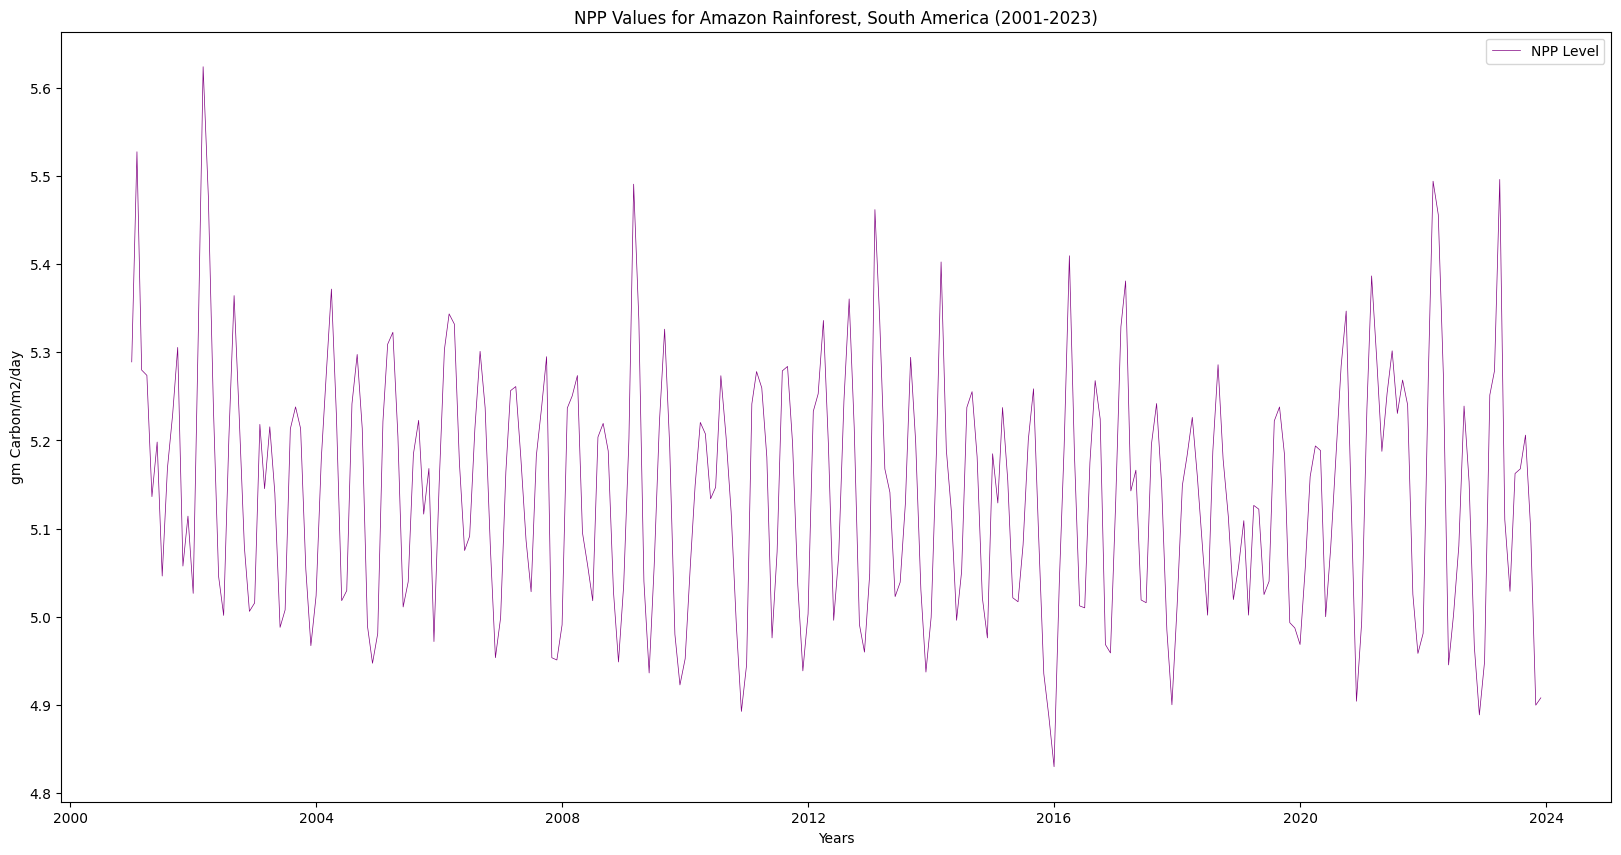

In [21]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10)) 

# Plot the time series analysis of the daily NPP Values for Amazon Rainforest, South America
plt.plot(
    df["date"], # X-axis: date
    df["max"], # Y-axis: Rh value
    color="purple", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="NPP Level", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("gm Carbon/m2/day")

# Insert title for the plot
plt.title("NPP Values for Amazon Rainforest, South America (2001-2023)")

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the MiCASA Land Carbon Flux dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the Net Primary Production (NPP) levels over the Amazon Rainforest, South America area for two distinctive months/years
5.	Create a table that displays the minimum, maximum, and sum of the Net Primary Production (NPP) values for a specified region
6.	Generate a time-series graph of the Net Primary Production (NPP) values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 